In [4]:
import torch
from src.data.fsd50k_dataset import SpectrogramDataset
from matplotlib import pyplot as plt
from torch import nn, optim

In [5]:
# The commented out inputs can still be included when creating the dataset
audio_config = {'feature': 'melspectrogram',
                # n_fft: 511
                # win_len:
                # hop_len:
                # normalize:
                'sample_rate': 22050,
                'min_duration': 1}
manifest_path = r"C:\Users\vismi\Documents\datasets\FSD50K\manifests\tr.csv" # Change this to your local path
labels_map = r"C:\Users\vismi\Documents\datasets\FSD50K\manifests\lbl_map.json" # Change this to your local path

In [6]:
# Make the dataset and dataloader
dataset = SpectrogramDataset(manifest_path, labels_map, audio_config)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

100%|██████████| 520966/520966 [00:10<00:00, 51736.77it/s]


torch.Size([520966, 200])


torch.Size([1, 96, 101])


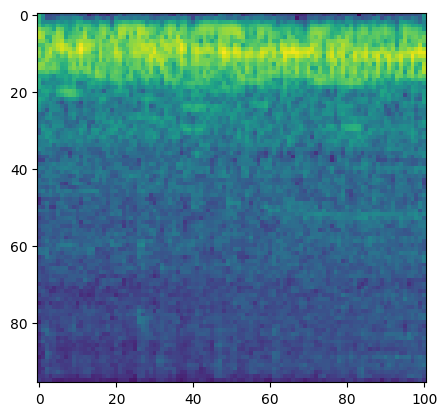

torch.Size([1, 1, 96, 101])


In [8]:
# Plot a random element of the dataset
spectrogram, target = next(iter(dataloader))
print(spectrogram.shape)
plt.imshow(spectrogram[0])
plt.show()

# Add the channels dimension which is missing and usually expected from vision transformers
input = spectrogram.expand(1, -1, -1, -1) # Create an extra empty dimension
input.permute(1, 0, 2, 3) # Permute so we have Batch - Channel - Width - Height
input = input.to(device)
print(input.shape)

In [9]:
from src.models.KWT import KWT
# Input arguments to Holger's vision transformer. The commented out lines can still be added but are optional.
# The input resolution needs to match the spectrogram. Either change the dataset to match the model or the model to match the dataset.
# The patch res needs to divide the input resolution.
model_harams = {
        'input_res': [96, 101],
        'patch_res': [96, 1],
        'num_classes': 3,
        'mlp_dim': 256,
        'dim': 64,
        'heads': 1,
        'depth': 12
        # dropout: 0.0
        # emb_dropout: 0.1
        # pre_norm: False
        # pool: mean
}
# Create the model
model = KWT(**model_harams)
model.to(device);

In [10]:
from src.models.ssformer import SSTransformer
# This is the self supervised transformer.
# It is based on the KWT model above. The model_embed_dim needs to match 'dim' from earlier
ss_model_harams = {
        'encoder': model,
        'model_embed_dim': 64,
        'ema_decay': 0.999,
        'ema_end_decay': 0.9999,
        'ema_anneal_end_step': 1000,
        'average_top_k_layers': 8, 
        'normalize_targets': True
}

transformer = SSTransformer(**ss_model_harams)
transformer.to(device);

In [11]:
# During self supervised training we give both the teacher and the student the same inputs.
# In practice the student and teacher are different models so their outputs will be different.
# x is the final latent state of the student (the KWT model)
# y is the averaged out latent states of the teacher (EMA KWT)
x, y = transformer(input, input)
print(x.shape, y.shape)

torch.Size([1, 1, 102, 64]) torch.Size([1, 1, 102, 64])


In [8]:
import math
# The loss is calculated between the two latent states
scale = math.sqrt(y.size(dim=-1))
criterion = nn.MSELoss(reduction="none")

print(f'Shape of criterion output: {criterion(x.float(), y.float()).shape}')
print(f'After first sum: {criterion(x.float(), y.float()).sum(dim=-1).shape}')
print(f'After second sum: {criterion(x.float(), y.float()).sum(dim=-1).sum().shape}, Value: {criterion(x.float(), y.float()).sum(dim=-1).sum()}')
loss = criterion(x.float(), y.float()).sum(dim=-1).sum().div(scale)
print(f'Final loss after scale: {loss}')
loss.backward()
print(loss)

Shape of criterion output: torch.Size([1, 1, 102, 64])
After first sum: torch.Size([1, 1, 102])
After second sum: torch.Size([]), Value: 135943.15625
Final loss after scale: 16992.89453125
tensor(16992.8945, device='cuda:0', grad_fn=<DivBackward0>)


In [9]:
optimizer = optim.Adam(transformer.parameters(), 
                       lr=0.0005,
                       betas=(0.9, 0.98),
                       eps=0.000001,
                       )
print(optimizer)
optimizer.step()

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.98)
    capturable: False
    differentiable: False
    eps: 1e-06
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)
